In [146]:
if False: # only run this once to filter the dataset
    import pandas as pd
    import numpy as np

    df = pd.read_csv("Data\\Y2EOL_Large_Dataset.csv")

    # eliminate the rows with blank entries

    labels = list(df.columns)
    obsol_idx = labels.index("OBSOLESCENCE_LTB_DATE")
    intro_idx = labels.index("INTRODUCTION_DATE")

    row_index = 0
    row_removed = False

    def isNan(val):
        return val != val # if True, then is NaN

    while row_index < len(df):
        column_index = 0
        row_removed = False
        while column_index < len(labels):
            if isNan(df.iloc[row_index,column_index]): # if the introduction date is later than the obsolescence date
                df = df.drop(df.index[row_index],axis=0)
                row_removed = True
                break
            else:
                column_index += 1
        if not row_removed:
            row_index += 1

    filename = "Data\\Y2EOL_Large_Dataset.csv"

    # writing to csv file
    with open(filename, 'w') as csvfile:
        # creating a csv writer object
        csvwriter = csv.writer(csvfile,lineterminator='\n')

        # writing the fields 
        csvwriter.writerow(labels)

        # writing the data rows 
        csvwriter.writerows(df.values)

In [147]:
import pandas as pd # Pandas is used for data manipulation
import numpy as np # Use numpy to convert to arrays
from sklearn.model_selection import train_test_split # Using Skicit-learn to split data into training and testing sets
from sklearn.ensemble import RandomForestRegressor # Import the model we are using
from sklearn.tree import export_graphviz # Import tools needed for visualization
import pydot
import matplotlib.pyplot as plt # Import matplotlib for plotting and use magic command for Jupyter Notebooks
from datetime import datetime
import csv

'''
Load and prepare the dataset
'''

# df = pd.read_csv('Data\\Y2EOL_Data.csv') # Read in data
df = pd.read_csv('Data\\Y2EOL_Large_Dataset.csv') # Read in data
df = df.drop("INTRODUCTION_DATE", axis=1)
df = df.drop("OBSOLESCENCE_LTB_DATE", axis=1)

# eliminate the rows where the obsolete date is later than the intro date

labels = list(df.columns)

row_index = 0

while row_index < len(df):
    intro_index = labels.index("INTRO_DATE (YRS SINCE 1980)")
    obsolete_index = labels.index("ACTUAL_OBSOLESCENCE_DATE (YRS SINCE 1980)")
    if df.iloc[row_index,intro_index] > df.iloc[row_index,obsolete_index]: # if the introduction date is later than the obsolescence date
        df = df.drop(df.index[row_index],axis=0)
    else:
        row_index += 1

labels = np.array(df['ACTUAL_OBSOLESCENCE_DATE (YRS SINCE 1980)']) # Labels are the values we want to predict
df = df.drop('ACTUAL_OBSOLESCENCE_DATE (YRS SINCE 1980)', axis = 1) # Remove the labels from the features; axis 1 refers to the columns
df = df.drop('PART', axis = 1) # Remove the part numbers from the features
df = pd.get_dummies(df) # One-hot encode the data (for categorical variables)
feature_list = list(df.columns) # Record the feature names
features = np.array(df) # Convert features to array

Standard Deviation: 2.3336789205515758
Mean: -0.04105084053618362
70.21% of the predictions fall within 0.5 years of the ground truths.


Text(0.5, 1.0, 'Error Distribution')

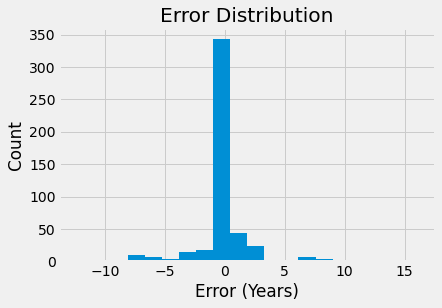

In [148]:
# Split the data into training and testing sets
# 80% is training data, 20% is test data
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.2, random_state = 42)

rf = RandomForestRegressor(n_estimators = 1000, random_state = 42) # Instantiate model with 1000 decision trees
rf.fit(train_features, train_labels) # Train the model on training data

predictions = rf.predict(test_features) # Use the random forest's predict method on the test data

errors = predictions - test_labels # Calculate the absolute errors
std = errors.std()
print("Standard Deviation: " + str(std))
print("Mean: " + str(np.mean(errors)))

threshold = 0.5
count = 0
for error in errors:
    if abs(error) <= threshold:
        count += 1

thres_percentage = count / len(errors) * 100.0
print(str(round(thres_percentage,2)) + "%" + " of the predictions fall within " + str(threshold) + " years of the ground truths.")

plt.hist(errors,bins=20)
plt.xlabel('Error (Years)')
plt.ylabel('Count')
plt.title('Error Distribution')

In [149]:
importances = list(rf.feature_importances_) # Shows how important each feature is in making the prediction
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)] # List of tuples with variable and importance
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True) # Sort the feature importances by most important first
if False:
    [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances] # Print out the feature and its importance

In [150]:
# remove the non-categorical variables first and reverse the one-hot encoding so the data looks presentable

df = pd.DataFrame(data=test_features,columns=feature_list) # 1st row as the column names
df = df.drop('INTRO_DATE (YRS SINCE 1980)', axis = 1)
df = df.drop('AVGPROCLIFE', axis = 1)
df = df.drop('PREDICTION_OBSOLESCENCE_DATE (YRS SINCE 1980)', axis = 1)

# seperate the dataset into vendor, product line, and inventory columns

vendor_df = df.filter(like='Vendor', axis=1) # filter the columns that have vendor in the name
pl_df = df.filter(like='PL Name', axis=1) # filter the columns that have product line in the name
lifecycle_df = df.filter(like='LIFECYCLE_STATUS', axis=1) # filter the columns that have lifecycle in the name

vendor_df = vendor_df.idxmax(axis=1) # reverses the one-hot encoding by finding the column that has a 1 in it
pl_df = pl_df.idxmax(axis=1)
lifecycle_df = lifecycle_df.idxmax(axis=1)

vendor_importance = 0
pl_importance = 0
lifecycle_importance = 0
intro_importance = 0
prediction_importance = 0
proc_importance = 0

for element in feature_importances:
    label = element[0]
    value = element[1]
    if "Vendor" in label:
        vendor_importance += value
    elif "PL Name" in label:
        pl_importance += value
    elif "LIFECYCLE" in label:
        lifecycle_importance += value
    elif "INTRO_DATE" in label:
        intro_importance = value
    elif "PREDICTION" in label:
        prediction_importance = value
    elif "AVGPROCLIFE" in label:
        proc_importance = value

print("Vendor Importance: " + str(vendor_importance))
print("PL Importance: " + str(pl_importance))
print("Lifecycle Importance: " + str(lifecycle_importance))

plot_features = list(['LIFECYCLE_STATUS','INTRODUCTION','EXISTING PREDICTION','VENDOR','PRODUCT LINE','AVGPROCLIFE'])
plot_importances = list([lifecycle_importance, intro_importance, prediction_importance, vendor_importance, pl_importance, proc_importance])

Vendor Importance: 0.09999999999999999
PL Importance: 0.02
Lifecycle Importance: 0.55


In [151]:
def floatHourToTime(fh):
    hours, hourSeconds = divmod(fh, 1)
    minutes, seconds = divmod(hourSeconds * 60, 1)
    return (
        int(hours),
        int(minutes),
        int(seconds * 60),
    )

def floatsToDates(values):

    values += 80
    values *= 365.25
    values
    formatted_values = np.copy(values).astype('str')

    for i in range(0,len(values)):
        excel_date = values[i]
        dt = datetime.fromordinal(datetime(1900, 1, 1).toordinal() + int(excel_date) - 2)
        hour, minute, second = floatHourToTime(excel_date % 1)
        dt = dt.replace(hour=hour, minute=minute, second=second)
        dt = str(dt).split(" ")
        del dt[-1]
        formatted_values[i] = dt[0]

    return formatted_values

print(predictions)
copy_predictions = np.copy(predictions)
copy_labels = np.copy(test_labels)
raw_predictions = np.copy(predictions)
raw_actuals = np.copy(test_labels)

formatted_predictions = floatsToDates(predictions)
formatted_actuals = floatsToDates(test_labels)

# before writing the data to a file, reformat the vendor and product line columns

i = 0

while i < len(feature_list):
    feature_name = feature_list[i]
    if "Vendor" in feature_name or "PL Name" in feature_name or "LIFECYCLE" in feature_name:
        test_features = np.delete(test_features,i,axis=1)
        del feature_list[i]
    else:
        i += 1

feature_list.append("VENDOR")
feature_list.append("PRODUCT LINE")
feature_list.append("LIFECYCLE_STATUS")

vendor_df = np.array(vendor_df)
pl_df = np.array(pl_df)
lifecycle_df = np.array(lifecycle_df)

for i in range(0,len(vendor_df)):
    split_string = str(vendor_df[i]).split("_")
    vendor_df[i] = split_string[1]

for i in range(0,len(pl_df)):
    split_string = str(pl_df[i]).split("_")
    pl_df[i] = split_string[1]

for i in range(0,len(lifecycle_df)):
    split_string = str(lifecycle_df[i]).split("_")
    lifecycle_df[i]  = split_string[2]

feature_list.append("PREDICTION")
feature_list.append("GROUND_TRUTH")

test_features = test_features.tolist()
formatted_predictions = formatted_predictions.tolist()
formatted_actuals = formatted_actuals.tolist()

for row_index in range(0,len(test_features)): #for each row, append the data value
    test_features[row_index].append(vendor_df[row_index])
    test_features[row_index].append(pl_df[row_index])
    test_features[row_index].append(lifecycle_df[row_index])

    test_features[row_index].append(formatted_predictions[row_index])
    test_features[row_index].append(formatted_actuals[row_index])

# name of csv file
filename = "Data\\Y2EOL_Predictions_RF.csv"

# writing to csv file
with open(filename, 'w') as csvfile: 
    # creating a csv writer object
    csvwriter = csv.writer(csvfile,lineterminator='\n')

    # writing the fields 
    csvwriter.writerow(feature_list) 

    # writing the data rows 
    csvwriter.writerows(test_features)

[35.40011    35.58       43.         31.31803675 35.58       37.49464775
 33.53707331 31.25       31.75735077 39.63683143 32.39625169 33.83
 40.79       28.35929743 29.03035363 31.25       33.83       29.67
 36.25845721 31.75735077 43.         29.03035363 43.         38.74027
 32.24549625 43.         31.75735077 31.31803675 31.75735077 24.9
 31.25       37.2751832  35.58       40.79       31.75735077 35.58
 33.38367017 40.54       43.         43.         40.54       31.75735077
 43.         43.         36.24196    37.2751832  35.58       29.03035363
 30.33367    31.20292279 40.16421111 31.31803675 40.54       35.58
 35.58       32.24549625 30.39541667 33.81058158 32.24549625 32.24549625
 35.58       43.         35.58       43.         31.31803675 43.
 30.88244071 40.54       35.58       43.         33.81058158 35.58
 35.58       35.58       36.41849504 38.50695382 34.59116636 33.83
 43.         33.81058158 38.43238332 43.         30.5152     43.
 43.         43.         37.2751832  27.

In [152]:
# examine the outliers

copy_test_features = list(test_features)
copy_feature_list = list(feature_list)
copy_feature_list.append("RAW PREDICTION")
copy_feature_list.append("RAW ACTUAL")

for row_index in range(0,len(copy_test_features)): # for each row, append the data value
    copy_test_features[row_index].append(raw_predictions[row_index])
    copy_test_features[row_index].append(raw_actuals[row_index])

row_index = 0

while row_index < len(copy_test_features):
    prediction = raw_predictions[row_index]
    actual = raw_actuals[row_index]
    threshold = 1.0
    if abs(prediction - actual) < threshold: # remove non-outliers
        copy_test_features = np.delete(copy_test_features,row_index,axis=0)
        raw_predictions = np.delete(raw_predictions,row_index,axis=0)
        raw_actuals = np.delete(raw_actuals,row_index,axis=0)
    else:
        row_index += 1

vendors = dict()
vendor_idx = copy_feature_list.index("VENDOR")

for row_index in range(0,len(copy_test_features)):
    vendor_name = copy_test_features[row_index][vendor_idx]

    if vendor_name in vendors:
        vendors[vendor_name] += 1
    else:
        vendors[vendor_name] = 1

print(vendors)

products = dict()
product_idx = copy_feature_list.index("PRODUCT LINE")

for row_index in range(0,len(copy_test_features)):
    product_name = copy_test_features[row_index][product_idx]

    if product_name in products:
        products[product_name] += 1
    else:
        products[product_name] = 1

print(products)

filename = "Data\\Y2EOL_Outliers_RF.csv"

# writing to csv file
with open(filename, 'w') as csvfile: 
    # creating a csv writer object
    csvwriter = csv.writer(csvfile,lineterminator='\n')

    # writing the fields 
    csvwriter.writerow(copy_feature_list)

    # writing the data rows 
    csvwriter.writerows(copy_test_features)

{'Vishay': 41, 'Micro Commercial Components': 9, 'onsemi': 10, 'NIC Components Corp': 4, 'Comchip Technology': 1, 'Maxim Integrated': 5, 'C&K': 1, 'PHOENIX CONTACT': 4, 'KOA Speer Electronics': 3, 'Rittal Inc': 2, 'Littelfuse': 4, 'IDEC': 1, 'SMC Diode Solutions Co. LTD': 1, 'NXP Semiconductors': 3, 'FUJITSU': 1, 'Western Digital': 2, 'Infineon Technologies AG': 2, 'TE Connectivity': 2, 'TT Electronics': 2, 'Amphenol ICC': 1, 'Cypress Semiconductor': 5, 'Cal-Chip Electronics': 2, 'Renesas Electronics': 3, 'Texas Instruments': 1, 'Ecliptek': 2, 'STMicroelectronics': 1, 'Panduit': 1, 'Molex': 1, 'Advantech': 1, 'MaxLinear, Inc': 1, 'Murata Manufacturing': 1, 'Bourns': 1, 'Analog Devices': 1, 'Semikron': 1}
{'TVS': 53, 'Rectifiers': 8, 'Inductor Surface Mount': 5, 'Linear Regulators': 7, 'Switch Rotary': 1, 'Box, Enclosure and Rack Accessories': 2, 'Ferrite Beads': 4, 'Misc Products': 2, 'Zener': 5, 'Switch Indicators': 1, 'Audio Amplifiers': 1, 'Interface Controllers': 1, 'Flash Cards': 

Text(0.5, 1.0, 'Variable Importances')

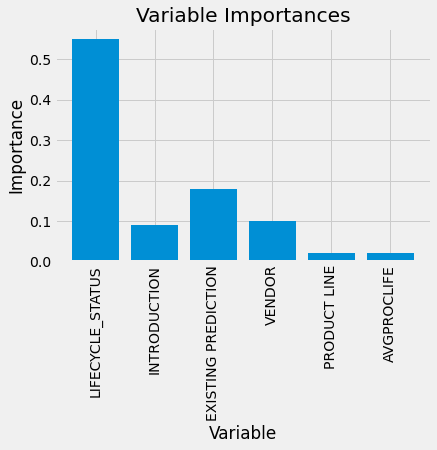

In [153]:
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(plot_importances)))
# Make a bar chart
plt.bar(x_values, plot_importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, plot_features, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance')
plt.xlabel('Variable')
plt.title('Variable Importances')

Text(0.5, 1.0, 'Actual and Predicted Values')

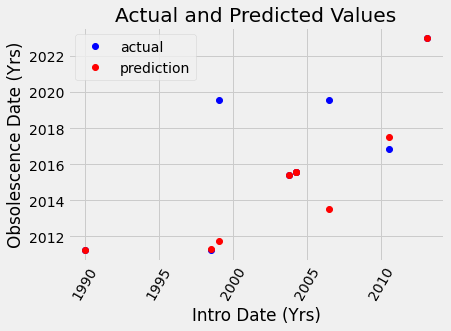

In [154]:
'''
INTRODUCTION DATE IS THE X COORDINATE, THE Y COORDINATE IS THE PREDICTION & ACTUAL
Y COORDINATE CAN BE ANY FORMAT AS LONG AS IT'S CONSISTENT
'''

def year_format(a):
    a += 1980
    return a

test_features = np.array(test_features)
test_features = test_features[0:9,:]
intro_dates = test_features[:,feature_list.index('INTRO_DATE (YRS SINCE 1980)')]

intro_dates = intro_dates.astype(float)
intro_dates = year_format(intro_dates)
test_labels = year_format(copy_labels)
predictions = year_format(copy_predictions)

# Plot the actual values
plt.plot(intro_dates, test_labels[0:9], 'ro', label = 'actual', color = 'blue')
# Plot the predicted values
plt.plot(intro_dates, predictions[0:9], 'ro', label = 'prediction', color = 'red')
plt.xticks(rotation = '60')
plt.legend()
# Graph labels
plt.xlabel('Intro Date (Yrs)')
plt.ylabel('Obsolescence Date (Yrs)')
plt.title('Actual and Predicted Values')